/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_29735/288131399.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_lemmatized'] = df[text_column].apply(lemmatize_text)
/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_29735/288131399.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_lemmatized'] = df['clean_text_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= min_word_length]))


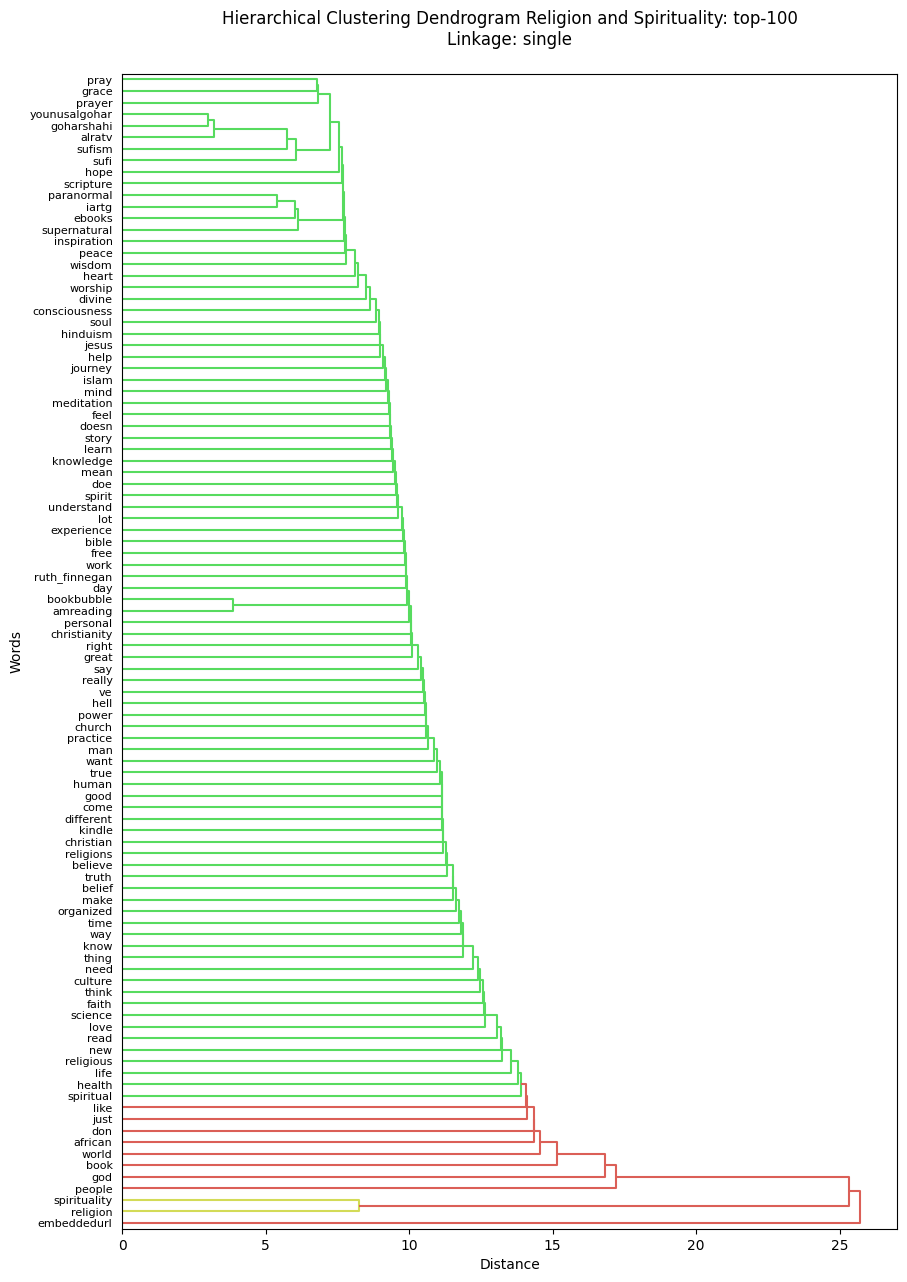

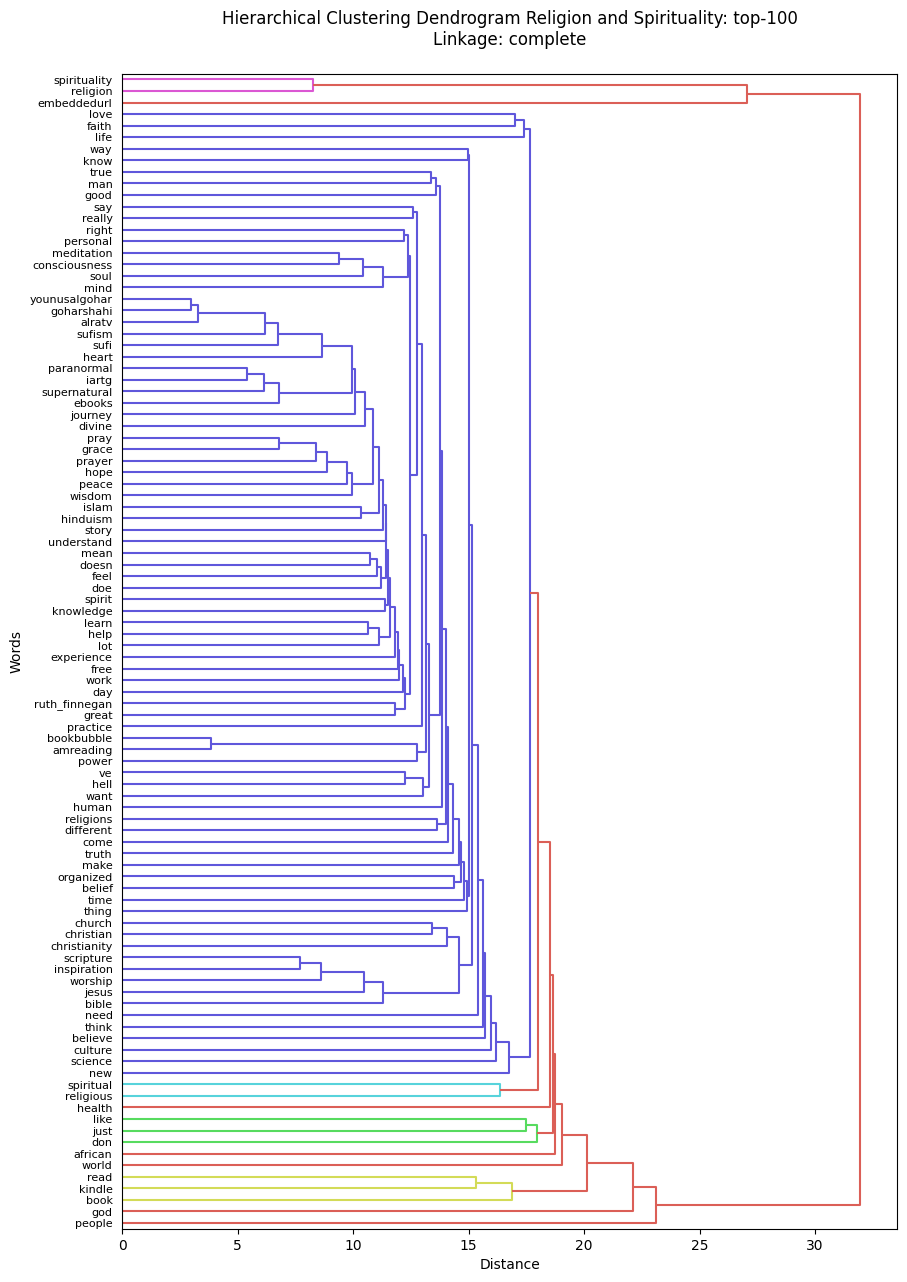

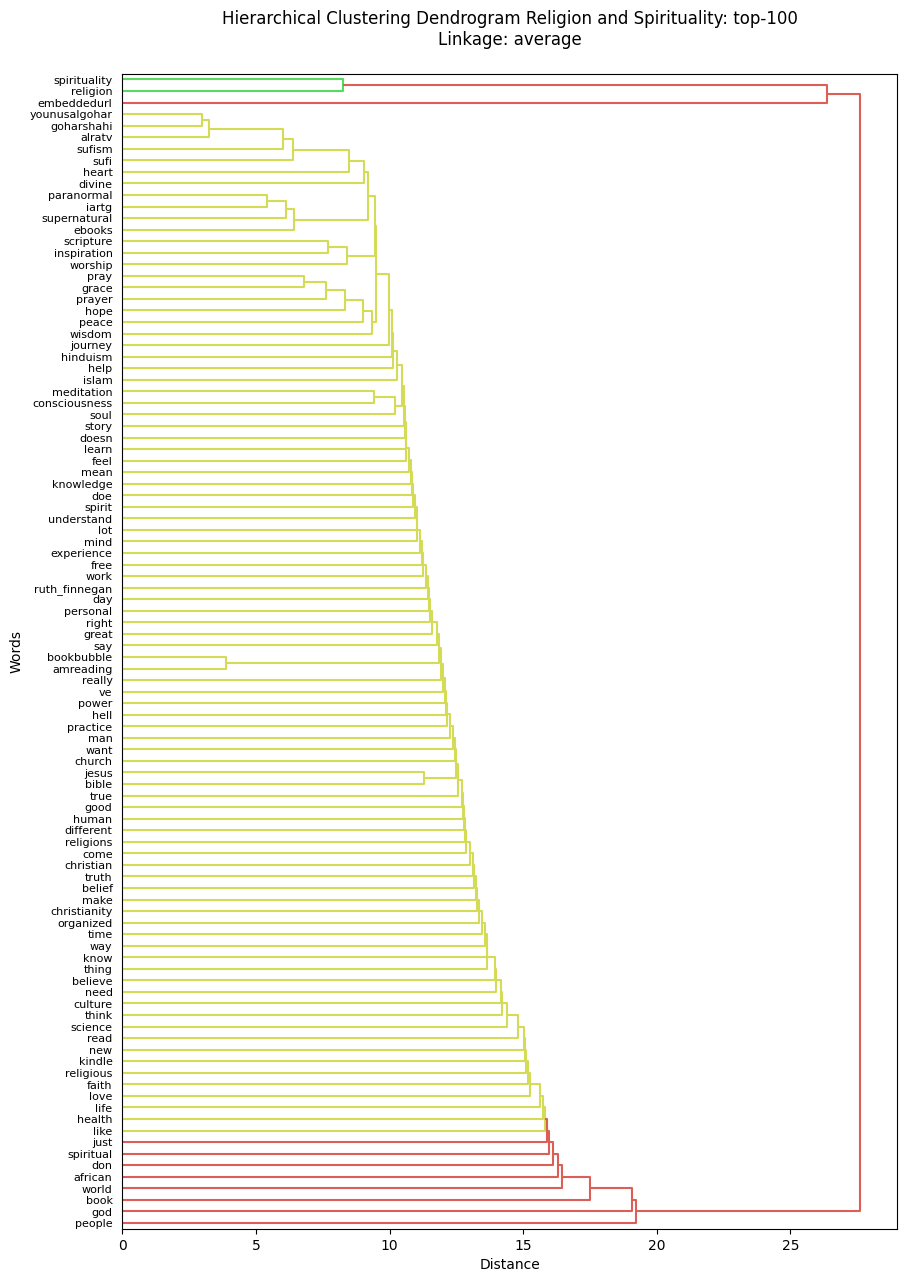

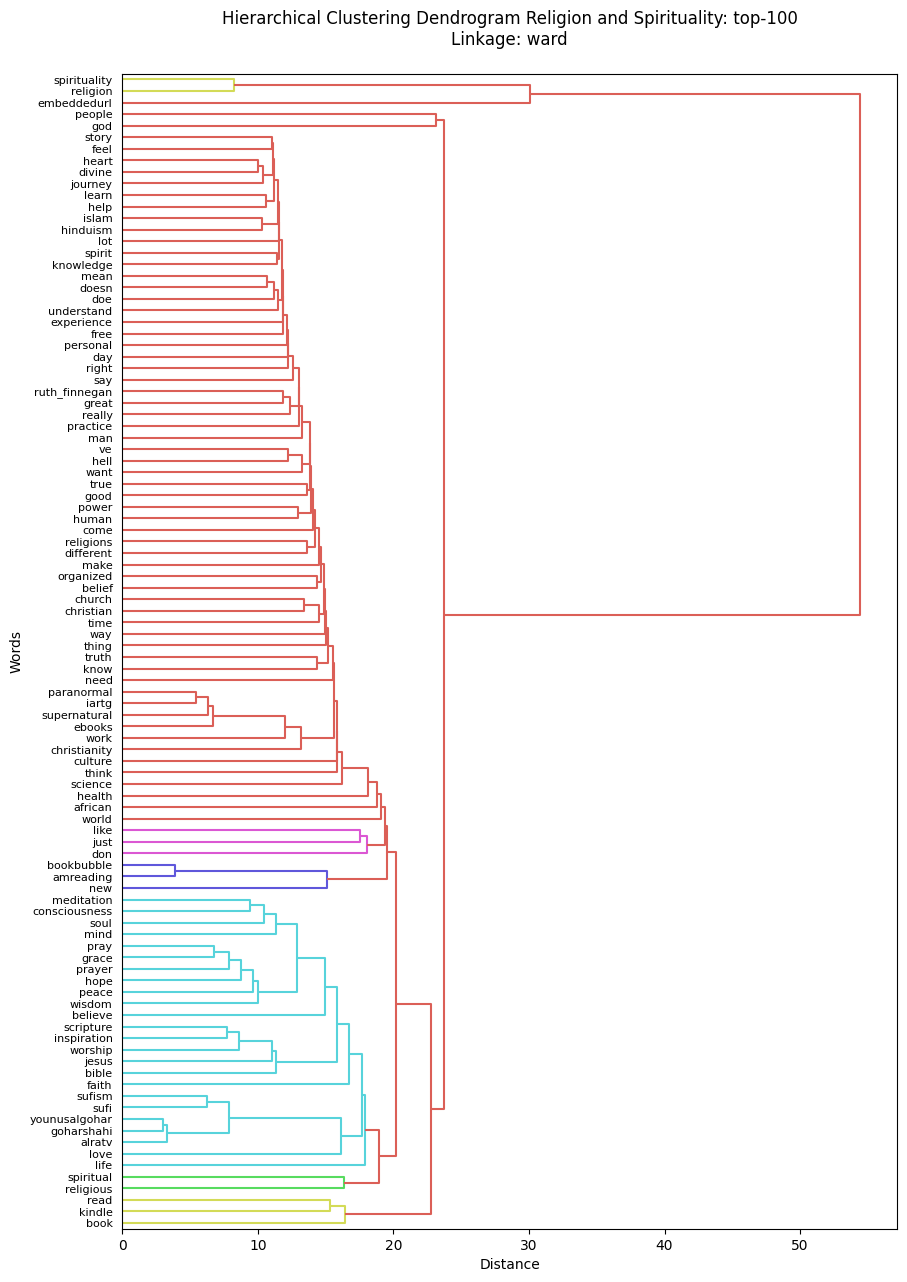

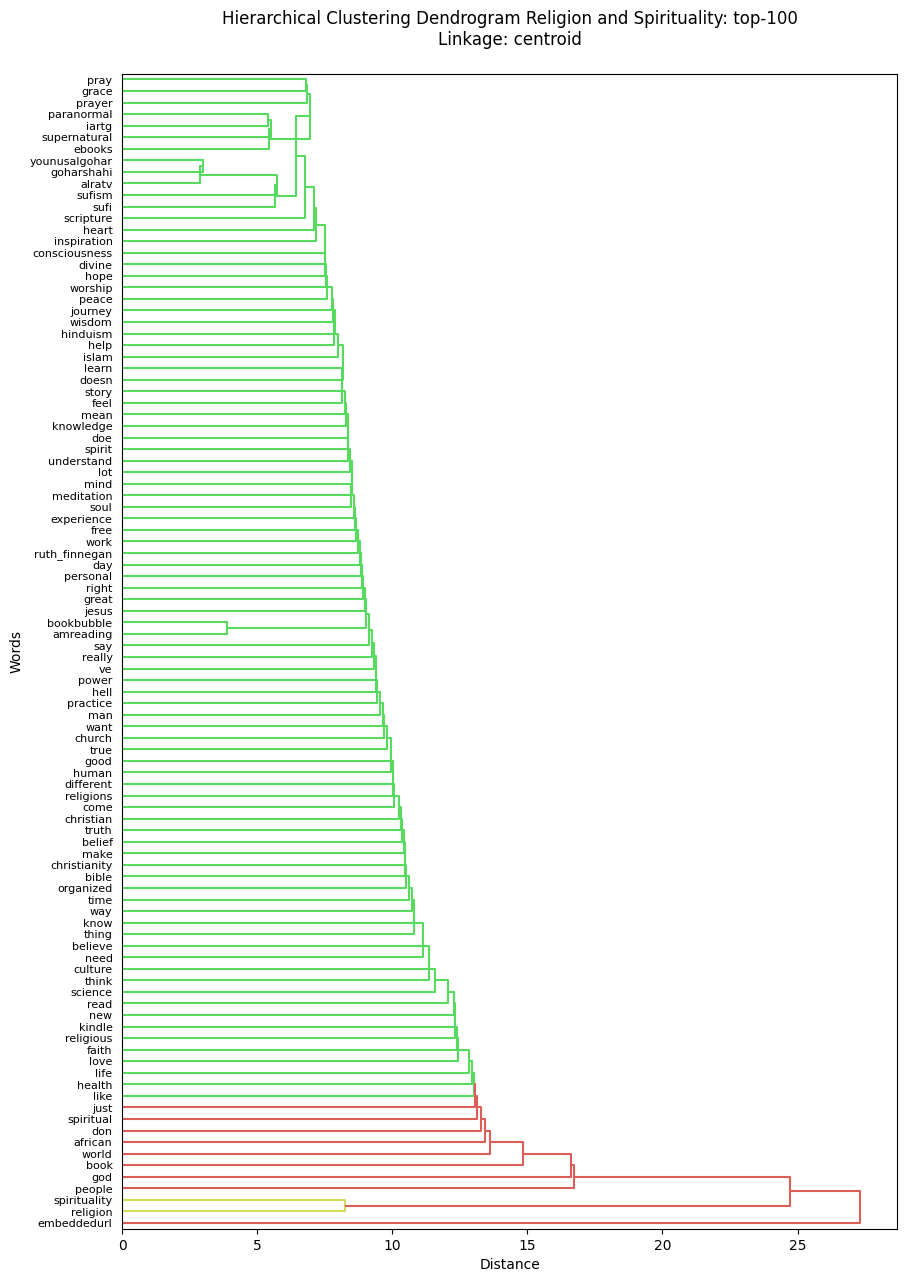

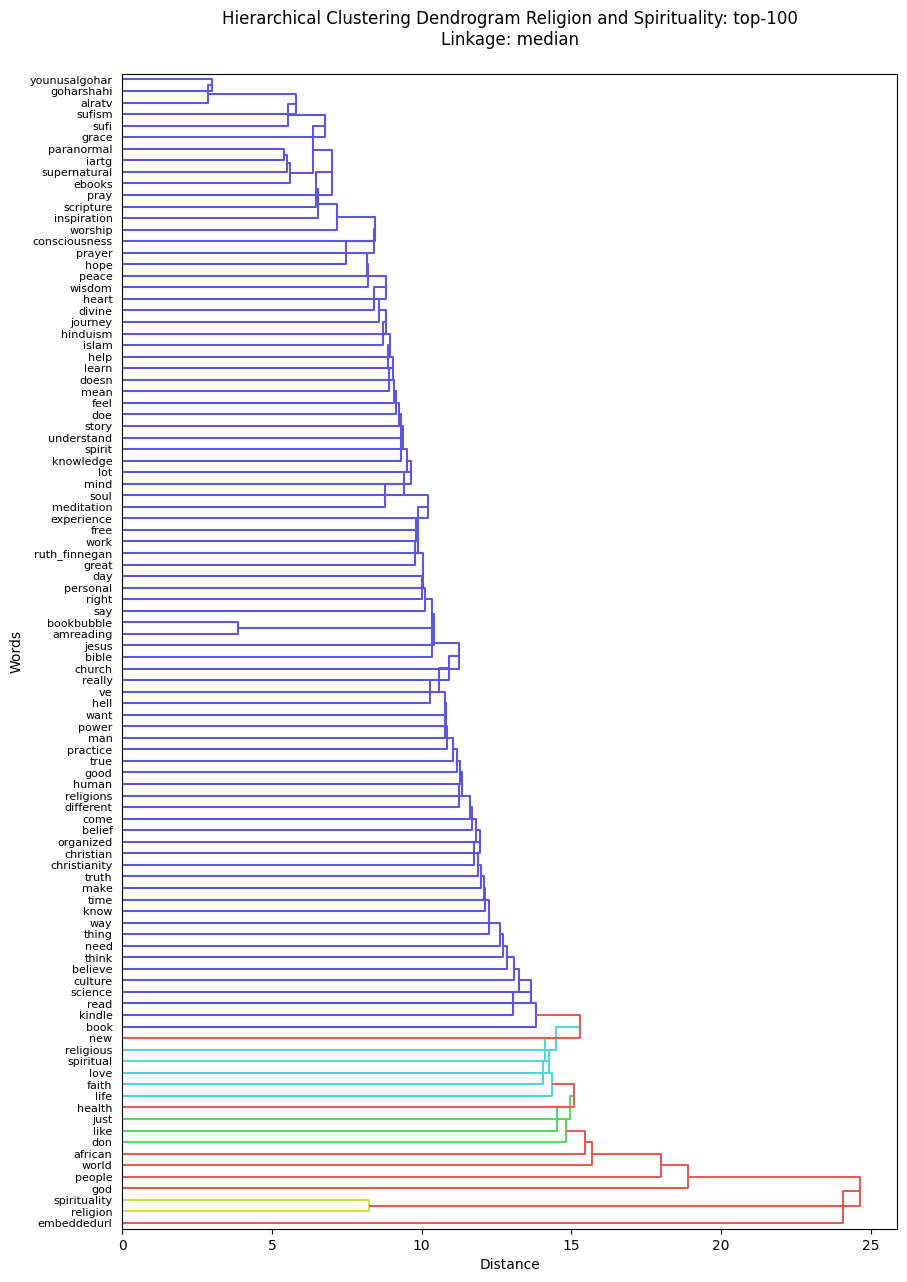

In [89]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer


def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocess_data(df, text_column='clean_text', min_word_length=3, max_features=100, custom_stopwords=None):
    if custom_stopwords is None:
        custom_stopwords = ENGLISH_STOP_WORDS

    df['clean_text_lemmatized'] = df[text_column].apply(lemmatize_text)
    # filter out short words
    df['clean_text_lemmatized'] = df['clean_text_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= min_word_length]))

    vectorizer = TfidfVectorizer(max_features=max_features, stop_words=custom_stopwords)
    X = vectorizer.fit_transform(df['clean_text_lemmatized'])

    return X, vectorizer.get_feature_names_out()



def hierarchical_clustering(X_transposed, method):
    linkage_matrix = linkage(X_transposed.toarray(), method=method)
    return linkage_matrix


def plot_dendrogram_save(linkage_matrix, labels, method, orientation='right', leaf_rotation=0, leaf_font_size=8,
                          color_threshold=None):
    custom_palette = sns.color_palette("hls")
    sns.set_palette(custom_palette)

    if color_threshold is None:
        color_threshold = linkage_matrix[-10, 2] if len(linkage_matrix) >= 10 else linkage_matrix[-1, 2]

    plt.figure(figsize=(10, 15))
    dendrogram(linkage_matrix, labels=labels,\
        orientation=orientation, leaf_rotation=leaf_rotation, 
        leaf_font_size=leaf_font_size, color_threshold=color_threshold,\
            distance_sort=True)

    plt.title(f'Hierarchical Clustering Dendrogram Religion and Spirituality: top-100\nLinkage: {method}\n')
    plt.xlabel('Distance')
    plt.ylabel('Words')

    # Save the plot to the dendrograms folder
    folder_path = 'dendrograms_True_100'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(f'{folder_path}/religion_AND_spirituality_{method}_100.png')
    plt.show()



file_path = '/Users/shtosti/Dropbox/study/UZH/FW23/SMA/topic_modelling_DEPO/data/with_clean_keybert_bigrams.csv'
df = load_dataset(file_path)
df_spirituality = df[df['clean_text'].str.contains('spirituality', case=False) & ~df['clean_text'].str.contains('religion', case=False)]
df_religion = df[df['clean_text'].str.contains('religion', case=False) & ~df['clean_text'].str.contains('spirituality', case=False)]
df_both = df[df['clean_text'].str.contains('spirituality', case=False) & df['clean_text'].str.contains('religion', case=False)]

X, feature_names = preprocess_data(df_both)
X_transposed = X.T

# linkage methods to try
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid', 'median']


for method in linkage_methods:
    linkage_matrix = hierarchical_clustering(X_transposed, method=method)
    plot_dendrogram_save(linkage_matrix, feature_names, method)
